# Лекция 2. Основы программирования на языках нижнего уровня

1. Режимы работы с памятью, режимы работы процессора x86-64.
2. Регистры процессора x86-64. Регистр флага. 
3. Данные, метки. Безусловные, условные переходы. Операторы сравнения.
4. Структура программы на языке ассемблера. Команда mov.
5. Примеры использования ассемблера, работа с отладчиком gdb.

## 1. Режимы работы с памятью, режимы работы процессора x86-64.

В 70-х годах прошлого века компьютер с памятью 64 Кб считался суперкомпьютером. Для адресации такой памяти хватало 16 бит. После того как появились модули памяти 128 Кб и даже 256 Кб, регистров размером 16 бит стало не хватать для адресации памяти. Тогда ввели 16-битные сегментные регистры. Вся память делилась на сегменты размером 64 Кб. Сегмент задавался сегментным регистром, а адрес – обычным регистром или непосредственно 16-битным значением адреса. Но даже после этих новаций можно было адресовать только 1 Мб физической памяти из-за особенности формирования физического адреса и особенностей архитектуры процессора.

Всё кардинально изменилось, когда был выпущен первый полноценный 32-разрядный процессор (Intel 80386): он мог работать в двух режимах – в обычном 16-разрядном, как старые процессоры, и в защищённом, в котором можно было адресовать до 4 Гб физической памяти. На процессоре Intel 80386 появились новые 32-разрядные регистры, с помощью которых можно было адресовать эту память; также он поддерживал набор команд, позволяющий работать с данными размером 32 бита. Сегментные регистры остались, но они не слишком сильно влияли на формирование адреса, а предназначались для защиты определённых областей памяти, которые могла задавать операционная система; отсюда и название этого режима. Впрочем, для того чтобы получить доступ к 4 Гб памяти, необязательно надо было переходить в защищённый режим: такая возможность существовала и в режиме реальных адресов, но защищённый режим давал намного больше новых возможностей, чем просто расширение физического адресного пространства до 4 Гб.

После выпуска первых процессоров с поддержкой технологии AMD64 появился и 64-битный режим, который являлся вариантом защищённого режима, рассчитанным только на 64-битную архитектуру. В нём важность сегментных регистров была снижена до минимума, а защита данных операционной системы полностью возложена на механизм трансляции страниц.

Существует три вида адресов:
1. **Физический**.
2. **Линейный (или виртуальный)**.
3. **Логический**.

**Физический адрес** – это адрес в системной памяти компьютера, именно тот адрес, который выставляется на шину адреса. 

Для того чтобы получить доступ к некоторому значению в памяти (в любом режиме), приложение должно указать сегмент и адрес в этом сегменте. Сегмент указывается в сегментном регистре или непосредственно значением (это значение может быть только 16-битным), а адрес – в обычном регистре или непосредственно значением (это значение может быть 16-, 32-, 64-битным в зависимости
от режима). Приложение может указать адрес разными способами, а сегмент можно вовсе не указывать. Если он не указан, то значение сегмента берётся из соответствующего (код, данные или стек) сегментного регистра. 

Адрес всегда будет в таком формате – **«сегмент:смещение»**; именно этот адрес и называется **логическим**.
После преобразования логического адреса (способ преобразования тоже зависит от режима процессора) получается абсолютный 20-, 32-, 64-битный адрес в зависимости от режима; этот адрес называется **линейным**. 

В режиме реальных адресов он сразу выставляется на шину адреса. 

В защищённом и 64-разрядном режимах этот адрес можно называть **виртуальным**, если активирован механизм
трансляции страниц (подробнее рассмотрим позже). Если механизм трансляции страниц не активирован, то линейный адрес становится
физическим, т. е. без преобразования выставляется на шину адреса. Если же механизм трансляции страниц включён, то линейный (он же виртуальный) адрес специальным образом преобразуется в физический адрес; способ преобразования задаётся самой операционной системой.

Современные процессоры x86-64 в основном могут работать в трёх основных режимах: **реальный режим, защищённый режим и 64-разрядный режим, или long mode (далее – long mode)**:
- **реальный режим** – это режим, в который переходит процессор после включения или перезагрузки. Это стандартный 16-разрядный режим, в котором доступно только 1 Мб физической памяти и возможности процессора почти не используются, а если и используются, то в очень малой степени. Иногда этот режим называют режимом реальных адресов, потому что в нем нельзя активировать механизм трансляции виртуальных адресов в физические. Это значит, что все адреса, к которым обращаются программы, являются физическими, т. е. без какого-либо преобразования будут выставлены на шину адреса. В этом режиме «родной» для процессора размер равен 2 байтам, или слову (WORD);
- **защищённый режим** (protected mode, или legacy mode по документации AMD) – это 32-разрядный режим; разумеется для процессоров x86 этот режим главный. В защищённом режиме 32-разрядная операционная система может получить максимальную отдачу от процессора, если ей это потребуется. В этом режиме можно получить доступ к 4-гигабайтному физическому адресному пространству, если память, конечно, установлена на материнской плате, а при включении специального механизма трансляции адресов можно получить доступ к 64 Гб физической памяти. В защищённый режим можно перейти только из реального режима. Защищённый режим называется так потому, что позволяет защитить данные операционной системы от приложений. В этом режиме «родной» для процессора размер данных – это 4 байта, или двойное слово (DWORD). Все операнды, которые выступают в этом режиме как адреса, должны быть 32-битными;
- **[long mode](https://en.wikipedia.org/wiki/Long_mode) («длинный режим», или IA-32e по документации Intel)** – это собственно сам 64-разрядный режим. По своему принципу работы он почти полностью сходен с защищённым режимом, за исключением нескольких аспектов. В этом режиме можно получить доступ к $2^{48}$ байтам физической памяти и к $2^{52}$ байтам виртуальной памяти. В 64-разрядный режим можно  перейти только из защищённого режима. В этом режиме «родной» для процессора размер данных – это двойное слово (DWORD), но можно оперировать данными размером в 8 байт. Размер адреса всегда 8-байтовый.

Помимо приведённых выше режимов есть ещё один режим. Это [**режим системного управления (System Management Mode)**](https://ru.wikipedia.org/wiki/System_Management_Mode), в который процессор переходит при получении специального прерывания SMI. Режим системного управления предназначен для выполнения некоторых действий с возможностью их полной изоляции от прикладного программного обеспечения и даже операционной системы. Переход в этот режим возможен только аппаратно. Режим системного управления может использоваться для реализации системы управления энергосбережением компьютера или функций безопасности и контроля доступа.

Помимо вышеперечисленных режимов работы процессор поддерживает следующие **два подрежима**:
- **режим виртуального процессора 8086** – это подрежим защищённого режима для поддержки старых 16-разрядных приложений. Его можно включить для отдельной задачи в многозадачной операционной системе защищённого режима;
- **режим совместимости для long mode**. В режиме совместимости приложениям доступны 4 Гб памяти и полная поддержка 32-разрядного и 16-разрядного кода; «родной» для процессора размер данных – это двойное слово. Режим совместимости, можно сказать, представляет собой в long mode то же самое, что и режим виртуального 8086 процессора в защищённом режиме. Режим совместимости можно включить для отдельной задачи в многозадачной 64-битной операционной системе. В режиме совместимости размер адреса 32-битный, а размер операнда не может быть 8-байтовым.

Нужно отметить, что в официальной документации производителей процессоров (Intel и AMD) немного другая
терминология. Если следовать официальной документации, есть два режима работы процессора: 32-битный и 64-битный. 32-битный режим в документации от AMD называется **legacy mode**, а в документации от Intel носит название **IA-32**. Он включает в себя режим реальных адресов и защищённый режим. 

64-битный режим в документации от AMD называется **long mode**, в документации от Intel – **IA32e**; он включает в себя **два подрежима**: сам 64-разрядный режим и режим совместимости.

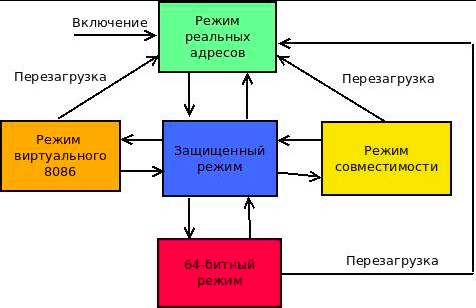

На рисунке изображена диаграмма режимов работы процессора и возможности перехода из одного режима в другой.

Мы будем изучать защищённый и 64-битный режимы работы ЦП.

## 2. Регистры процессора x86-64. Регистр флага.

Для выполнения программы на языке ассемблера регистры играют особую роль. Регистры в процессоре x86-64 можно разделить на **четыре категории**: 
1. регистры общего назначения (РОН);
2. специальные регистры для приложений (РСН);
3. сегментные регистры;
4. специальные регистры режима ядра.

Доступность регистров зависит от режима работы процессора и режима доступа к памяти. 

В защищённом режиме, в режиме реальных адресов и режиме совместимости доступны следующие регистры:
- регистры общего назначения: восемь 32-разрядных регистров **EAX, EBX, ECX, EDX, ESI, EDI, ESP, EBP**; 16-разрядные **AX, BX, CX, DX, SI, DI, SP, BP** (они являются младшими частями 32-разрядных регистров); 8-битные регистры **AH, BH, CH, DH и AL, BL, CL, DL** (старшие и младшие части 16-битных регистров соответственно);
- 32-разрядный **EIP** (**IP** в реальном режиме) – указатель инструкции;
- 16-разрядные сегментные регистры: **CS, DS, SS, ES, FS, GS**;
- 32-разрядный регистр флагов – **EFLAGS**;
- 80-битные регистры математического сопроцессора **ST0-ST7** и др.;
- 64-битные **[MMX-регистры](https://ru.wikipedia.org/wiki/MMX) – MM0 – MM7**;
- 128-разрядные [XMM-регистры](https://ru.wikipedia.org/wiki/SSE) – XMM0 – XMM7 и 32-битный MXCSR;
- 32-разрядные **регистры управления CR0 – CR4**; 
- регистры-указатели системных таблиц **GDTR, LDTR, IDTR** и регистр задачи **TR**;
- 32-разрядные регистры отладки – **DR0 – DR3, DR6, DR7**;
- [MSR-регистры](https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B7%D0%B0%D0%B2%D0%B8%D1%81%D0%B8%D0%BC%D1%8B%D0%B5_%D1%80%D0%B5%D0%B3%D0%B8%D1%81%D1%82%D1%80%D1%8B#:~:text=%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B7%D0%B0%D0%B2%D0%B8%D1%81%D0%B8%D0%BC%D1%8B%D0%B5%20%D1%80%D0%B5%D0%B3%D0%B8%D1%81%D1%82%D1%80%D1%8B%20(Model%2DSpecific%20Registers,%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D0%B9%20%D0%BF%D0%BE%D0%BC%D0%B5%D1%89%D0%B0%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2%20%D1%80%D0%B5%D0%B3%D0%B8%D1%81%D1%82%D1%80%20ECX.).

В режиме реальных адресов доступны не все вышеуказанные регистры, но регистры управления доступны в любом случае. В режиме реальных адресов нельзя использовать некоторые регистры размером более 16 бит.

При переключении процессора в 64-разрядный режим программе доступны следующие регистры:
- регистры общего назначения: 64-разрядные **RAX, RBX, RCX, RDX, RSI, RDI, RSP, RBP и R8, R9, …, R15**; 32-разрядные **EAX, EBX, ECX, EDX, ESI, EDI, ESP, EBP, R8D – R15D** (являются младшими частями 64-разрядных регистров); 16-разрядные **AX, BX, CX, DX, SI, DI, SP, BP, R8W– R15W** (являются младшими частями 32-разрядных регистров); 8-битные регистры **AH, BH, CH, DH и AL, BL, CL, DL, SIL, DIL, SPL, BPL, R8L – R15L** (старшие и младшие части 16-битных регистров соответственно);
- 64-разрядный **RIP** – указатель инструкции;
- 16-разрядные сегментные регистры: **CS, DS, SS, ES, FS, GS**;
- 64-разрядный регистр флагов – **RFLAGS**;
- 80-битные регистры математического сопроцессора **ST0 – ST7**;
- 64-битные MMX-регистры (**MM0 – MM7**);
- 128-разрядные XMM-регистры – **XMM0 – XMM15** и 32-битный **MXCSR**;
- 64-разрядные регистры управления **CR0 – CR4 и CR8**; регистры-указатели системных таблиц **GDTR, LDTR, IDTR** и регистр задачи TR;
- 64-разрядные регистры отладки – **DR0 – DR3, DR6, DR7**;
- **MSR**-регистры.

Регистры сегментов напрямую участвуют в формировании адресов, каждый сегментный регистр указывает на свой сегмент памяти,
а именно: CS – сегмент кода, DS – сегмент данных, SS – сегмент стека; остальные три регистра дополнительные и могут не использоваться программой. Свободная работа с ними не всегда возможна; например в защищённом и 64-разрядном режимах загружать в них можно лишь определённые значения. 

В защищённом и 64-разрядном режимах доступность регистров зависит уровня привилегий, на котором выполняется программа.

Регистр общего назначения ESP (RSP) всегда указывает на верхушку стека, но при этом нам ничто не мешает использовать его в других целях, хотя тогда будет потеряна возможность нормальной работы со стеком. Вообще все регистры общего назначения можно свободно использовать в своих целях, но **следует помнить, что некоторые регистры используются некоторыми командами**: например, EBP
(RBP) обычно указывает на начало фрейма в стеке, где хранятся локальные данные подпрограмм.

Указатель инструкции EIP (RIP) напрямую использовать нельзя – данный регистр используется самим процессором.
Регистры STn, MMn, XMMn используются математическим сопроцессором
при работе с числами с плавающей точкой.
Регистры CRn, DRn, регистры-указатели системных таблиц, MSR-регистры являются системными и управляются ключевыми механизмами работы процессора.

Часто последовательность дальнейших действий процессора должна зависить от результата выполнения предыдущих действий. Соответственно возникает необходимость где-то хранить признаки результатов этих действий. Для этих целей используется **регистр флагов**. Каждый бит этого регистра отвечает за свой признак результата. Для  16-битного режима регистр флагов имеет обозначение **FLAGS**, для 32-битного - **EFLAGS**, для 64-битного - **RFLAGS**. Ниже представлено описание битов **RFLAGS**.


| Номер бита | Обозначение |Описание|
|--------------------|----------------------|---------------|
| 0 | **CF**|Флаг переноса (Carry flag): показывает, был ли при сложении перенос или заимствование при вычитании. Используется в качестве входных данных для инструкций сложения и вычитания.|
|1| - |Зарезервирован (всегда установлен)|
|2|**PF**|Флаг четности: устанавливается, если младшие 8 битов результата содержат четное число единиц.|
|3|-|Зарезервирован (всегда сброшен) |
|4|**AF**|Дополнительный флаг переноса: указывает, был ли при сложении перенос или заимствование при вычитании младших 4 битов.|
|5|-|Зарезервирован (всегда сброшен)|
|6|**ZF**|Флаг нулевого результата (Zero flag): устанавливается, если результат операции равен нулю|
|7|**SF**|Флаг знака результата (Sign flag): устанавливается, если результат операции отрицательный|
|8|**TF**|Флаг трассировки - прерывания выполнения (Trap flag): используется при одношаговой отладке|
|9|**IF**|Флаг разрешения прерывания: установка этого бита разрешает аппаратные прерывания|
|10|**DF**|Флаг направления:контролирует направление обработки. Если не установлен, то порядок от самого младшего до самого старшего адреса. Если установлен, то порядок обратный - от самого старшего до самого младшего адреса.|
|11|**OF**|Флаг переполнения (Overflow flag): если устанавлен, то операция привела к переполнению со знаком|
|12,13|**IOPL**|Уровень привилегий ввода-вывода (I/O privilege level): уровень привилегий текущего выполняемого потока. IOPL 0 — это режим ядра, а 3 — пользовательский режим|
|14|**NT**|Флаг вложенной задачи (Nested task flag): управляет цепочкой прерываний|
|15|-|Зарезервирован (всегда сброшен)|
|16|**RF**|Флаг возобновления (Resume flag): используется для обработки исключений во время отладки|
|17|**VM**|Флаг режима виртуальной машины 8086: если установлен, режим совместимости с 8086 активен. Этот режим позволяет запускать некоторые приложения MS-DOS в контексте операционной системы в защищенном режиме|
|18|**AC**|Флаг проверки выравнивания (Alignment check flag): если установлен, проверка выравнивания памяти активна. Например, если установлен флаг AC, сохранение 16-битного значения по нечетному адресу вызывает исключение проверки выравнивания. Процессоры x86 могут выполнять невыровненный доступ к памяти, когда этот флаг не установлен, но количество требуемых командных циклов может увеличиться|
|19|**VIF**|Флаг виртуального прерывания (Virtual interrupt flag): виртуальная версия флага IF в виртуальном режиме 8086|
|20|**VIP**|Флаг ожидания виртуального прерывания: устанавливается, когда прерывание находится в состоянии ожидания в виртуальном режиме 8086|
|21|**ID**|Флаг разрешения идентификации процессора: если этот бит установлен, то поддерживается инструкция cpuid. Эта инструкция возвращает идентификатор процессора и информацию о его функциях|
|22-63|-|Зарезервированы (всегда сброшены)|

Чаще остальных используются флаги переноса **CF**, нуля **ZF**, знака **SF** и переполнения, которые называют **флагами состояния**. 

Состояние некоторых наиболее часто используемых битов в регистре флагов можно изменить, используя специально отведённые для этого команды. Ниже перечислены команды, работающие с флагами процессора:
1. **CLC** – сброс флага переноса (CF=0).
2. **CLD** – сброс флага направления (DF=0).
3. **CLI** – сброс флага разрешения прерываний (IF=0).
4. **LAHF** – сохранение в регистре AH содержимого первого байта регистра флагов (флаги SF, ZF, AF, PF, CF)
5. **SAHF** – сохранение регистра AH в первый байт регистра флагов (флаги SF, ZF, AF, PF, CF); биты с зарезервированными значениями игнорируются.
6. **STC** – установка флага переноса в единицу (CF=1).
7. **STD** – установка флага направления в единицу (DF=1).
8. **STI** – разрешения прерываний (IF=1).

Все команды, кроме CLI и STI, являются непривилегированными. 

## 3. Данные, метки. Безусловные, условные переходы. Операторы сравнения.

### Данные.

Конечно, использовать регистр флагов приходится при организации так называемых **условных переходов**.

Но прежде рассмотрим все это в логической последовательности.

Начнем с понятия **данные**. Данные в программах на ассемблере объявляются (или резервируются) с помощью **директив данных**, которые показаны в таблице

|Название директивы данных|Размер в байтах|
|--------------|---------------|
|**DB**|1|
|**DW, DU**|2|
|**DD**| 4|
|**DF, DP**|6|
|**DQ**|8|
|**DT**|10|

За директивой описания данных должно следовать одно или несколько числовых значений, разделенных запятыми. Эти выражения определяют значения для простейших элементов данных, размер которых зависит от того, какая директива
используется. Вместо числового значения может стоять символ; впоследствии он будет интерпретирован как числовой код символа (символов). Вот ряд примеров:




In [ ]:
db 89A
db 13ed, 0f67
db "z", "a", 456
dw "WE" ; то же самое, что и db 57h, 45h
dd 01F243D5Eh
dd "WEGa" ; то же самое, что и db 57h, 45h, 47h, 61h
dq 1122334455667788h

За директивами db и du могут следовать строки неопределённого размера; в результате каждый символ будет интерпретирован как его числовое значение. Отличие директивы **du** от **db** заключается в том, что каждый символ интерпретируется
двумя байтами, старший из которых заполняется нулём, например:

In [ ]:
db "assembler"
то же самое, что и
db 61h, 73h, 73h, 65h, 6Dh, 62h, 6Ch, 65h, 72h
du "assembler"
то же самое, что и
db 0, 61h,0, 73h,0, 73h,0, 65h,0, 6Dh,0, 62h,0, 6Ch,0, 65h,0, 72h

Для описания большей последовательности одинаковых данных предназначена директива **dup**. Она используется после директивы определения данных. Перед ней должно стоять число повторений, а после неё (в скобках) – значение или цепь значений для повторения. 

In [ ]:
db 7 dup (1Ah)
db 6 dup (45h, 0A3h, 90h)
dd 13 dup (0A713E445h)
dd 9 dup (0A713E445h, 0F8D3E412h)
dw 5 dup (?)

Если после директивы определения данных идёт вопросительный знак, то начальное значение этих данных будет не определено. Данные, помеченные вопросительным знаком, называются **неинициализированными**. Неинициализированные данные не включаются в исполняемый файл и будут доступны лишь после загрузки программы в память (разумеется, если это поддерживается форматом исполняемых файлов, в который будет компилироваться программа). Неинициализированные данные позволяют сократить размер исполняемого файла, т. к. в большинстве случаев не важно какое начальное значение имеет переменная. 

### Метки.

Чтобы иметь возможность обратиться к выделенной и заполненной какими-то данными области памяти, используют **метки**.
    
**Метка** – идентификатор, который используется в программе и возвращает адрес памяти, по которому она находится. Метка – это главная форма взаимодействия с данными в памяти. 

Если метка используется в программе, то фактически на месте метки будет стоять адрес, на который она указывает.

Существуют разные способы определения меток. Простейший из них – **двоеточие после названия метки**. За этой директивой на той же строке может следовать инструкция или директива. Она определяет метку, значение которой равно смещению следующей директивы или инструкции. Этот метод обычно используется, чтобы пометить места в коде, но также можно пометить и данные.

Данные обычно помечаются другим методом – это **написание названия метки перед директивой объявления данных**. Метка возвращает адрес данных, перед которыми она объявлена. Компилятор запоминает размер данных, на которые  указывает эта метка, и при использовании с ней операндов, несовместимых по размеру, уведомляет об этом. При использовании этого метода объявления меток отпадает необходимость использования операторов размера (word, dword, qword и т. д.).

Третий метод объявления меток – самый гибкий: это **использование директивы label**. После этой директивы должно следовать имя метки, потом (опционально) размер оператора, далее (тоже опционально) оператор “at” и числовое выражение, определяющее адрес, на который данная метка должна ссылаться. В качестве адреса может использоваться другая метка, ведь метка это то же самое что и адрес, на который она указывает.

In [ ]:
metka1: dd "qwerty"

metka2:
  and ...
  xor ...
      
label metka3 dword at metka2
   mov ...

В командах метку можно использовать как адрес памяти, на которую она указывает:

In [ ]:
metka1: dd ...
data1 db ...

mov al, [data1]
metka2:
  mov ebx,eax
  mov ebx, dword [metka1]

Метка, имя которой начинается с точки, обрабатывается как **локальная**, и её имя прикрепляется к имени последней глобальной метки (с названием, начинающемся с чего угодно, кроме точки) для создания полного имени этой метки. Так, вы можете использовать короткое имя (начинающееся с точки) где угодно перед следующей глобальной меткой, а в других местах придется пользоваться полным именем. 

Метки, начинающиеся с двух точек, – **исключения**. Они имеют свойства глобальных, но не создают новый префикс для локальных меток. 

In [ ]:
globmetka1:
  .locmetka1 dd …
  .locmetka2:
  mov [.locmetka1], eax
  mov word [.locmetka2], cx
  mov word [.locmetka3], cx ; ошибка!
  mov word [globmetka2.locmetka3], cx
globmetka2:
  .locmetka3: …
  mov [..globmetka3.locmetka4], cx ; ошибка!
  mov [globmetka3.locmetka4], cx ; ошибка!
..globmetka3:
  .locmetka4: dw …
  mov [.locmetka4], cx

Метка \\$ обозначает текущее смещение или смещение текущей команды.

Например, чтобы бесконечно зациклить выполнение программы, достаточно написать в программе jmp $, т. е. это будет ее безусловный «прыжок на саму себя».

Метки бывают **ближние и дальние**. Дальность или близость метки определяется только тем, в каком месте она используется. Одна и та же метка, используемая в двух разных командах, в одной команде может быть ближней, а в другой – дальней. 

**Ближняя метка –та, которая определена на далее чем 127 байт после и не далее чем на 128 байт до команды, где она используется.**

**Все метки, которые находятся за этими пределами, являются дальними.**

Дальность или близость меток имеет значение только с командами передачи управления.

Также при объявлении данных может быть необходимо объявлять разные структуры данных, в то же время находящиеся по одному адресу. Это может пригодиться, когда одни и те же данные в зависимости от контекста могут интерпретироваться по-разному, и удобнее было бы использовать разные названия переменных. В таких случаях применяется **директива virtual**. 

In [ ]:
param dd ?
virtual at param
 LowPart dw ?
 HighPart dw ?
end virtual
virtual at param
 Byte1 db ?
 Byte2 db ?
 Byte3 db ?
 Byte4 db ?
end virtual

В приведенном примере, обратившись к переменной LowPart мы получим младшую часть переменной param, а обратившись к переменной Byte3 получим третий байт переменной param, или первый байт переменной HighPart. Также с помощью данной директивы можно задавать данные, находящиеся по адресу, который адресует какой-нибудь регистр общего назначения, например:

In [ ]:
virtual at eax
 Char1 db ?
 Char2 db ?
 Char3 db ?
 Char4 db ?
end virtual

Тогда инструкции тождественны:

In [ ]:
mov bl, [Char1] =  mov bl, [eax]

mov bl, [Char3] = mov bl, [eax+2]. 

### Переходы.

**Переход** – это передача управления другой команде. 

Фактически переход осуществляется после выполнения каждой команды. В регистре EIP (IP, RIP) находится адрес команды, которая выполнится следующей. После выполнения команды процессор выполняет команду, находящуюся в памяти, на которую указывает EIP (IP, RIP). Этот регистр доступен только для чтения и изменить его нельзя – он изменяется самим процессором. Но иногда надо выполнить не следующую команду, а команду, которая находится по другому адресу. Для этого и выполняются команды переходов. 

Переходы бывают **безусловные и условные**.

Есть **три основные команды безусловной передачи управления**: **JMP, CALL и RET**. 

Фактически **команда JMP** изменяет регистр EIP (IP, RIP) на значение, которое было указано в качестве операнда. Операндом может быть непосредственно значение в памяти, регистр, содержащий адрес, или непосредственно значение
адреса. Если привести эквивалент команды 

**jmp <адрес>**, 

то он будет такой:

**mov eip, <адрес>**

**Команда CALL** производит переход с сохранением в стеке адреса следующей команды, для того чтобы функция (или процедура), на которую производится переход, могла вернуться назад для дальнейшего выполнения вызвавшего её кода.

У этой команды формат такой же, что и у команды JMP. Эквивалент этой команды CALL:

**push eip**

**jmp <адрес>**

**Команда RET** берёт из верхушки стека адрес возврата и переходит по нему.

Она не принимает никаких параметров. Эквивалент команды RET: 

**pop eip**


Также существует **команда RETN**, которая принимает один операнд. Операнд
задаёт количество байтов, которое необходимо «вытолкнуть» из стека перед возвращением из процедуры. Эквивалент команды RETN n следующий:

**pop temp**

**sub esp, n**

**mov eip, temp**

Для **дальнего возврата**, т. е. возврата, когда произошла межсегментная передача управления, предназначена **команда RETF**. 

Инструкция RETF также может принимать параметр, подобно инструкции RETN. Эквивалент инструкции RETF n следующий:

**pop temp_eip**

**pop temp_cs**

**sub esp, n**

**mov cs, temp_cs**

**mov eip, temp_eip**

Заметим, что на самом деле эквиваленты команд, которые были приведены выше, работать не будут, поскольку регистр EIP изменить нельзя.

**Команды условного перехода** передают управление, только если выполнено условие. 

Таких команд много, и каждая передаёт управление в зависимости от значения некоторого флага в регистре флагов. 

Например, команда JZ передаёт управление другому адресу, только если выставлен флаг ZF. 

**Команды условного перехода принимают в качестве параметра ближнюю метку**, т. е. могут передать управление не далее чем на 127 байт вперёд и 128 байт назад.

Ниже приведена таблица команд условного перехода

|Команда | Условие| Реализация|
|------|----|-----|
|**JA**  | X>Y | CF=0 and ZF=0|
|**JAE**| X >= Y| CF = 0|
|**JB** |X < Y| CF = 1|
|**JBE**| X < Y| CF = 1 or ZF = 1|
|**JC**|| CF = 1|
|**JCXZ**|| CX = 0|
|**JE** (то же, что и **JZ**)| X = Y| ZF = 1|
|**JG**| X > Y| ZF = 0 and SF = OF|
|**JGE**| X >= Y| SF = OF|
|**JL** |X < Y| SF! = OF|
|**JLE**| X <= Y| ZF = 1 or SF! = OF|
|**JNA** |X <= Y| CF = 1 or ZF = 1|
|**JNAE**| X < Y| CF = 1|
|**JNB**| X >= Y| CF = 0|
|**JNBE**| X > Y| CF = 1 and ZF = 0|
|**JNC**|| CF = 0|
|**JNE**| X! = Y| ZF = 0|
|**JNG** |X <= Y| ZF = 1 or SF! = OF|
|**JNGE**| X < Y| SF! = OF|
|**JNL**| X >= Y| SF = OF|
|**JNLE**| X > Y| ZF = 0 and SF = OF|
|**JNO** ||OF = 0|
|**JNP**|| PF = 0|
|**JNS**|| SF = 0|
|**JNZ**| X! = Y| ZF = 0|
|**JO**| |OF = 1|
|**JP**|| PF = 1|
|**JPE**|| PF = 1|
|**JPO**|| PF = 0|
|**JS**|| SF = 1|
|**JZ**| X = Y| ZF = 1|

### Операторы сравнения

Команды условного перехода чаще всего используются вместе с **операторами сравнения**. 

Чаще всего используемая инструкция сравнения – это **команда CMP**. Она сравнивает операнды и изменяет регистр флагов.

Формат команды: **cmp <операнд1>, <операнд2>**

В качестве первого операнда может выступать регистр или значение памяти любого размера (1, 2, 4, 8 байт). В качестве второго операнда может выступать регистр, значение памяти или непосредственное значение. 

Значение не может быть 64-битным. Одновременно двух значений памяти быть не может. Если 32-битное значение сравнивается с 64-битным, то оно расширяется нулями. 

Иногда имеет смысл использовать **команду TEST**. Формат этой команды почти такой же, как и у команды CMP, но только в качестве второго операнда не может выступать значение памяти. Эта команда осуществляет операцию «логического И» и изменяет только флаги SF, ZF, PF. Команда TEST полезна для проверки соответствия значения операнда некоторой битовой маске.

## 4. Структура программы на языке ассемблера. Команда mov.

### Структура программы на языке ассемблера.

Написанную программу ассемблер транслируем в некий массив чисел, которые последовательно загружаются в некоторую область памяти. Затем при запуске программы в эту область памяти будет передано управление (в регистр EIP будет записан адрес из этой области памяти - точка входа) и процессор начнет выполнение программы. Ясно, что в многозадачном режиме все задачи работают с общей однородной памятью, но операционная система может устанавливать для пользовательской задачи разные возможности доступа к различным областям памяти. В частности, некоторые области памяти могут быть доступны задаче только для чтения, но не для изменения. Некотурую область памяти можно позволить рассматривать как машинный код - доступ на исполнение. Область, в которой задача может модифицировать данные доступна на запись. С памятью однако запрет на чтение не случается, поскольку тогда эта область просто недоступна программе.

Для реализации этой технологии операционные системы выстраивают виртуальное адресное пространство пользовательской задачи, разделив его на тка называемые **секции**.

Важная из этих секций - **секция кода** - создается для хранения исполняемого кода, данная секция помечается ключевым словой **executable** и имеет названние **'.text'** - точка в названии обязательна:

In [ ]:
section '.text' executable

Следующие две секции предназначены для хранения данных. Одна из них так и называется **секция данных** - обозначается **'.data'**. Эту секцию часто сопровождают ключевым словом **writable** - содержимое секции становится доступно для изменения. Другая секция называется **секция неинициализированных данных** (или **BSS-секция**), обозначается **'.bss'** - предназначена для переменных, для которых начальное значение не задано. Секция BSS может во время работы программы увеличиваться в размерах, что позволяет создавать новые переменные на этапе выполнения.

Память, полученную во время работы программы, часто называют **кучей (heap)**. 

In [ ]:
section '.data' writable
section '.bss' writable

Еще одна важная секция - **секция стека** - туда можно помещать промежуточные результаты. Секция стека всегда присутствует в программе и как-то специально не объявляется.

Нужно отметить, что программист может создавать любое количество своих собственных секций, давая им свои имена. Такие секции выполняют роль аналогично подпрограммам на языках высокого уровня.

### Команда mov.

Одна из самых часто используемых команд языка ассемблера - это пересылка данных из одного места в другое. Эта команда обзначается **mov**.

Команда имеет два операнда, которые записываются через запятую:

In [ ]:
mov <Приемник>, <Источник>

В синтаксисе AT&T приемник, источник меняются местами.

In [ ]:
mov rax, rbx ; копирует данные из регистра rbx в регистр rax

Существует несколько вариантов операндов для команды mov:

- **непосредственный операнд**, задающий значение прямо в команде;
- **регистровый операнд**, предписывающий взять значение из заданного регистра или поместить результат в регистр;
- **операнд типа память**, задающий адрес, по которому в памяти находится нужное значение, или по которому нужно записать некоторое значение.

Ясно, что не все комбинации пар операндов являются допустимыми. Например, непосредственный операнд не может быть в команде mov первым. Есть еще ограничение - **нельзя, чтобы сразу два операнда были типа память**. Все остальные комбинации являются допустимыми, т.е. командой  mov мы может:
1. скопировать значение из регистра в регистр;
2. скопировать значение из регистра в память;
3. скопировать значение из памяти в регистр;
4. записать в регистр определенное число;
5. записать в область памяти определенное число.

Рассмотрим примеры для каждого из этих вариантов:

In [ ]:
format ELF64
public _start
public exit

section '.data' writable ;задаем секцию данных
  my dq "abcdifgh"
  my2 dd 666 

section '.text' executable ; задаем секцию кода
_start:
  mov rax, 10 ; записываем в регистр rax число 10
  mov rbx, rax ; записываем значение из регистра rax в регистр rbx
  mov rdx, [my] ; записываем 64 бита, начиная с адреса, на который указывает метка my в регистр rdx
  mov rdx, [rax]; значение регистра rax считается адресом памяти, из которой значение записывается в регистр rdx
  mov [my], rbx ; записываем значение из регистра rbx (64 бита) в память, начиная с адреса, на который указывает метка my
  mov [my2], dword 777 ;записывает в память число 777, дополненное до 32 бит
  mov [my2], 333 ; преобразование происходит автоматически к типу dword
  mov byte [my2], 231 ;по адресу будет записан всего один байт

  call exit ;вызываем как подпрограмму код завершения программы

section '.exit' executable
exit:
  mov rax, 1
  mov rbx, 0
  int 0x80

Нужно обратить внимание, что **для получения адреса памяти, на который указываются метки, их нужно брать в квадратные скобки**.

Также можно заметить, что метка **my** объявлена как **dq** (8 байт) - только в этом случае возможна пересылка из(в) 64-битный регистр. Например, такое определение приведет к ошибке:

In [ ]:
section '.data' writable ;задаем секцию данных
  my dw "abcdifgh"

section '.text' executable ; залаем секцию кода
_start:
  mov rdx, [my]
  mov [my], rbx 

In [ ]:
mov rdx, [my]
processed: mov rdx,[my]
error: operand sizes do not match.

Также можно обратить внимание на пересылку непосредственно числа в память:

mov [my2], dword 777

Здесь использовано явное приведение типа числа к типу данных, которые хранит ячейка. Если этого не сделать, то приведение будет к типу, который указан при объявлении метки.

Код:

mov byte [my2], 231

демонстрирует, что пересылать можно и меньшие порции данных, только их размер в этом случае нужно обязательно указывать.

## 5. Примеры использования ассемблера, работа с отладчиком gdb.

**Пример 1.**

Вывести из заданной памяти заданное количество байт.

In [ ]:
format ELF64

public _start
public exit
public print_symb

section '.bss' writable
  array db 'a', 'b', 'c', 'd'
  place db 1
  
section '.text' executable
  _start:
    xor rcx, rcx
    .iter:
       mov al, [array+rcx]
       push rcx
       call print_symb
       pop rcx
       inc rcx
       cmp rcx,4
       jne .iter
    call exit

print_symb:
  push rax
  mov eax, 4
  mov ebx, 1
  pop rdx
  mov [place], dl
  mov ecx, place
  mov edx, 1
  int 0x80
  ret
    
exit:
  mov eax, 1
  mov ebx, 0
  int 0x80


**Пример 2.**

Заполнить область памяти 20 раз значением 'a', пробежав по ней, увеличить значение каждой ячейки - первую на 0, вторую на 1, и т.д.

Вывести полученные в области памяти значения на экран.

In [ ]:
format ELF64

public _start
public exit
public print_symb

section '.bss' writable
  array db 20 dup ('a')
  place db 1
  
section '.text' executable
  _start:
    xor rcx, rcx
    .iter1:
       mov al, [array+rcx]
       add al, cl 
       mov [array+rcx],byte al
       inc rcx
       cmp rcx,20
       jne .iter1
    xor rcx, rcx  
    .iter2:
       mov al, [array+rcx]
       push rcx
       call print_symb
       pop rcx
       inc rcx
       cmp rcx,20
       jne .iter2
    call exit

print_symb:
  push rax
  mov eax, 4
  mov ebx, 1
  pop rdx
  mov [place], dl
  mov ecx, place
  mov edx, 1
  int 0x80
  ret
    
exit:
  mov eax, 1
  mov ebx, 0
  int 0x80

**Пример 3.**

Вывести заданное число на экран

In [ ]:
;Выводим число на экран

format ELF64

public _start
public exit
public print_symbl

section '.data' writable
  place db ?
  place2 dq 666777888
  
section '.text' executable
  _start:
    mov rax, [place2]
    mov rcx, 10
    xor rbx, rbx
    iter1:
      xor rdx, rdx
      div rcx
      add rdx, '0'
      push rdx
      inc rbx
      cmp rax,0
    jne iter1
    iter2:
      pop rax
      call print_symbl
      dec rbx
      cmp rbx, 0
    jne iter2
 mov rax, 0xA
 call print_symbl
 call exit


section '.print_symbl' executable   
   ;input:
   ;  rax=symbol
   ;output:
   ;  stdout
   print_symbl:
     push rbx
     push rdx
     push rcx
     push rax
     push rax
     mov eax, 4
     mov ebx, 1
     pop rdx
     mov [place], dl
     mov ecx, place
     mov edx, 1
     int 0x80
     pop rax
     pop rcx
     pop rdx
     pop rbx
     ret

section '.exit' executable    
  exit:
    mov eax, 1
    mov ebx, 0
    int 0x80

При отладке программ на ассемблере удобно использовать отладчик gdb. Следующие скриншоты демонстрируют его использование на примере последней программы.

Запуск отладчика с исполняемой программой:

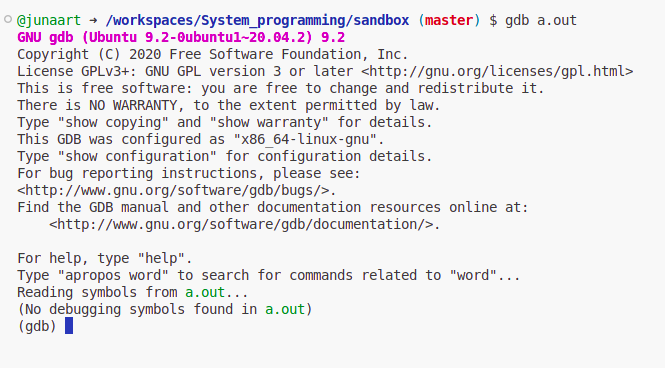

Если сейчас выполнить команду **run**, то программа будет выполнена сразу. Поэтому лучше вначале добавить **точку останова**. Для установки точки прерывания на конкретный адрес в программе применяется команда **break**, которой после символа звездочки * передается адрес метки. Например, установка точки прерывания на метке _start выглядит так:

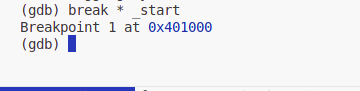

Теперь запустим программу:

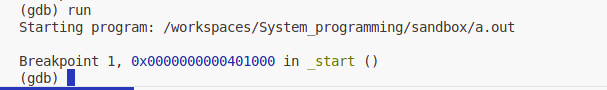

Видно, что отладчик остановил выполнение программы на точке останова, указав ее адрес.

Теперь мы можем пошагово запускать нашу программу и просматривать текущие результаты. Для этого вначале выполним дизассемблирование кода:

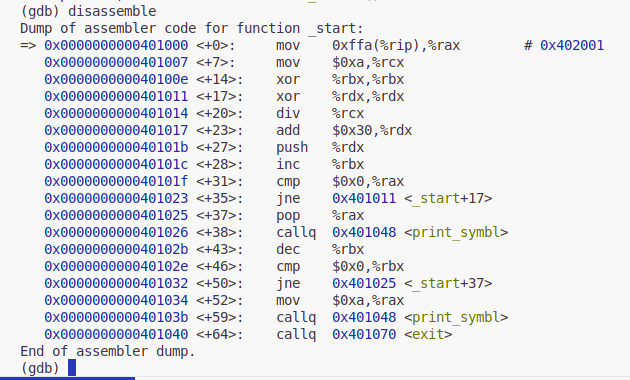

Видно, что напротив текущей выполняемой строки стоит символ **=>**.

С помощью команды **stepi** можно перейти к следующей строке кода и т.д.:

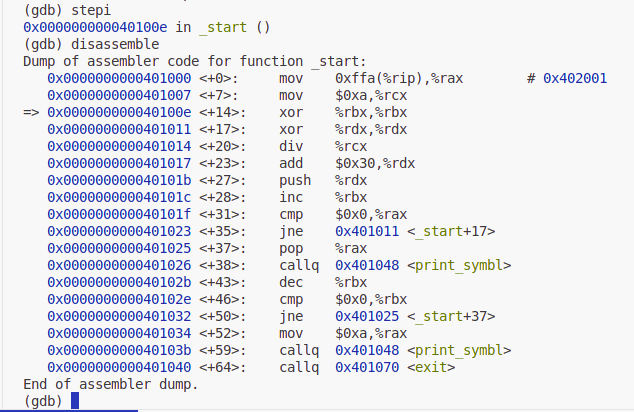

На каждом из этих этапов можно смотреть различную информацию о ходе выполнения программы с помощью команды **info**:

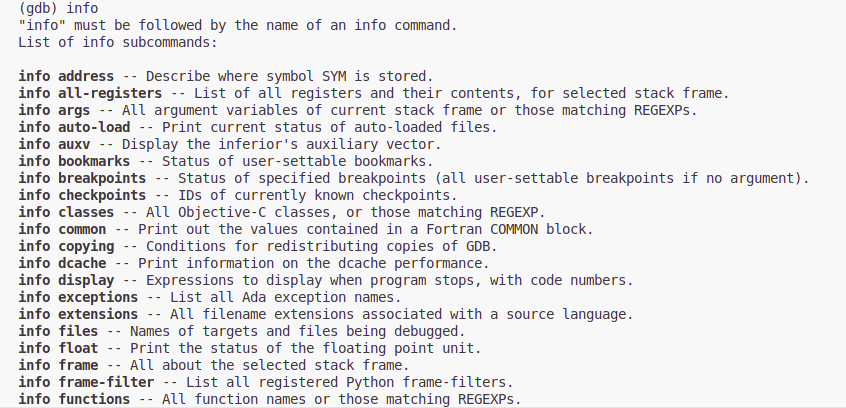

Вот так можно посмотреть состояние регистров процесссора (команда **info registers**):

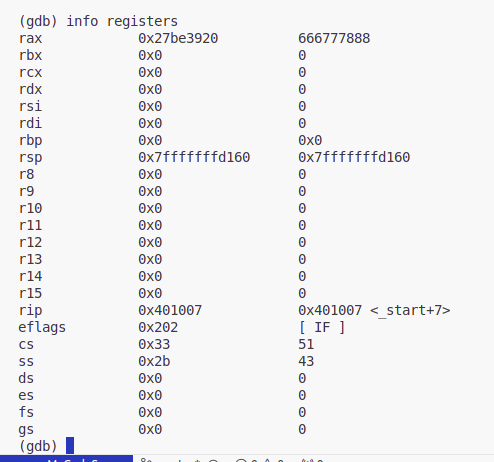

Вместо печати всех регистров мы можем вывести на консоль только один - интересующий нас регистр с помощью команды **print**, которой передается имя регистра, предваряемое символом $. Например, для вывода значения регистра **rax** применяется команда:

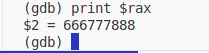

